# Modeling v2.0

My first set of models didn't perform very well. I only had 4 features (one of which was not very important), so that seems like an area for improvement. Some additional features which could be helpful are:

* A sentiment rating for the review text, rating is as either negative, positive or neutral
* A listing of the top 3 most similiar books, based on a cosine similarity analsyis of each book's text description

For the second feature, I'll use that list of most similiar books by looking at:
* The average rating of each book 
* The average rating assigned to those books by that reader's cluster

__First, reload our data:__

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Book Features:

* Create clusters
* Create list of most similiar books
* Use similiar book list to add "rating of most similiar books" feature

In [3]:
books = pd.read_csv('data/books_step3_output.csv', index_col = 'book_id')
books.head()

,text_reviews_count,average_rating,similar_books,description,authors,num_pages,publication_year,ratings_count,title,count_similar_books
book_id,,,,,,,,,,
13571772,5,4.28,"['13590139', '105963', '207585', '10503130', '...",The questions plaguing Captain America's dream...,['37450'],146,2012,51,Captain America: Winter Soldier (The Ultimate ...,161
35452242,1,4.05,[],The fight for Jason Delgado's life and soul be...,"['16209952', '853385']",160,2012,6,Bounty Hunter 4/3: My Life in Combat from Mari...,2
707611,6,4.06,[],These are the stories that catapulted Superman...,"['81563', '89537']",272,1997,51,"Superman Archives, Vol. 2",2
27036536,9,4.15,[],PRODUCT DESCRIPTION: The first new volume of G...,"['14965', '3188368', '131836', '7507599']",224,2016,39,"War Stories, Volume 3",2
11827783,26,3.16,"['6651573', '8835785', '15060759', '9466897', ...",Sir Arthur Conan Doyle's dauntless detective r...,"['61231', '4980321']",144,2011,114,Sherlock Holmes: Year One,203


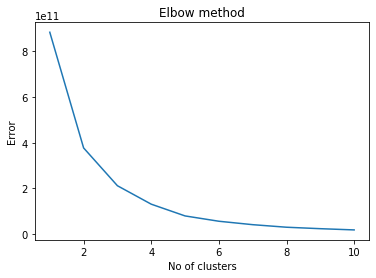

In [4]:
# Create book cluster feature
from sklearn.cluster import KMeans
x = books.drop(['description','title', 'similar_books','authors'], axis=1).values

Error = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(x)
    kmeans.fit(x)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

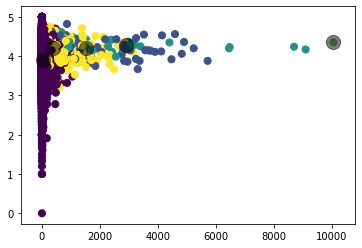

In [5]:
kmeans3 = KMeans(n_clusters=5)
y_kmeans3 = kmeans3.fit_predict(x)
plt.scatter(x[:, 0], x[:, 1], c=y_kmeans3, s=50, cmap='viridis')

centers = kmeans3.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [6]:
# Create cluster column
books['cluster'] = y_kmeans3

In [7]:
books.cluster.value_counts()

0    33048
4      747
1      103
2       26
3        1
Name: cluster, dtype: int64

## Book Feature #2: Similar Books List

Using cosine similarity, will create a list of similiar books using the description field.

In [8]:
# Create a similarity list of books based on description
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
books['description'] = books['description'].fillna('')
tfidf_matrix = tfidf.fit_transform(books['description'])
tfidf.get_feature_names()[10000:10015]

['caboodle',
 'cabot',
 'cabral',
 'cabret',
 'cabs',
 'cacat',
 'caceres',
 'cache',
 'cached',
 'caches',
 'cachet',
 'cachi',
 'cackling',
 'cacofonix',
 'caconofix']

In [9]:
# use linear kernal to compute a cosine similarity score
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [10]:
# Check
print(cosine_sim[0])
print(type(cosine_sim[0]))
print(len(cosine_sim[0]))

[1.         0.02388782 0.         ... 0.02371836 0.02134669 0.00323146]
<class 'numpy.ndarray'>
33925


In [11]:
# Trying this a different way, will create a function that returns the names of similiar books.
# Will need a reverse map of indices (book_id) given a title.

# Create reverse indices mapping - to get the book_id of given its place in cosine_sim
indices = pd.Series(books.index)
indices[:10]

0    13571772
1    35452242
2      707611
3    27036536
4    11827783
5    12349665
6    18955715
7    19115865
8     9858341
9    13082921
Name: book_id, dtype: int64

In [23]:
# Create a function to take the index of a cosine_sim book, sort the enumerated scores for that
# book as a list of tuples. Then lookup the book_id for the top books, using the indices map.
# Then return the titles and average ratings for similiar books # 2 & 3 (ignore #1 bc it will b
# itself.)

def get_similar_ratings(index, cosine_sim=cosine_sim):
    # Get the pairwise similarity scores for all books with that book - use enumerate to keep
    # scores tied with index, for identification.
    sim_scores = list(enumerate(cosine_sim[index]))
    
    # Sort the books based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the top 3 most similar books, ignoring the first
    sim_scores = sim_scores[1:4]
    
    # Get the book_ids for those books
    book_ids = [i[0] for i in sim_scores]
    
    return books['average_rating'].iloc[book_ids]

In [29]:
%timeit type(get_similar_ratings(2).values)

42.4 ms ± 3.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
# Loop through all the books, using the function above to create a list of similar book ratings
books['top3_similar_ratings'] = [get_similar_ratings(x) for x in range(len(books))]

In [42]:
books.top3_similar_ratings.head(5)

book_id
13571772    book_id
106052      4.28
106041      4.28
1609...
35452242    book_id
6420318     4.03
29214708    4.46
3596...
707611      book_id
381244      4.00
707595      4.21
2424...
27036536    book_id
448079     3.38
95405      3.91
674626...
11827783    book_id
17973194    3.72
6651573     4.04
8353...
Name: top3_similar_ratings, dtype: object

In [48]:
print(books.top3_similar_ratings.iloc[2].iloc[0])

4.0


In [46]:
# Create functions to access the values from above

def get_first_rating(index):
    return books.top3_similar_ratings.iloc[index].iloc[0]

def get_second_rating(index):
    return books.top3_similar_ratings.iloc[index].iloc[1]

def get_third_rating(index):
    return books.top3_similar_ratings.iloc[index].iloc[2]

In [47]:
get_first_rating(2)

4.0

In [49]:
books['most_similar_book_avg_rtg'] = [get_first_rating(x) for x in range(len(books))]

In [50]:
books['2nd_similar_book_avg_rtg'] = [get_second_rating(x) for x in range(len(books))]

In [51]:
books['3rd_similar_book_avg_rtg'] = [get_third_rating(x) for x in range(len(books))]

In [52]:
books.head()

,text_reviews_count,average_rating,similar_books,description,authors,num_pages,publication_year,ratings_count,title,count_similar_books,cluster,top3_similar_ratings,most_similar_book_avg_rtg,2nd_similar_book_avg_rtg,3rd_similar_book_avg_rtg
book_id,,,,,,,,,,,,,,,
13571772,5,4.28,"['13590139', '105963', '207585', '10503130', '...",The questions plaguing Captain America's dream...,['37450'],146,2012,51,Captain America: Winter Soldier (The Ultimate ...,161,0,book_id 106052 4.28 106041 4.28 1609...,4.28,4.28,4.32
35452242,1,4.05,[],The fight for Jason Delgado's life and soul be...,"['16209952', '853385']",160,2012,6,Bounty Hunter 4/3: My Life in Combat from Mari...,2,0,book_id 6420318 4.03 29214708 4.46 3596...,4.03,4.46,3.98
707611,6,4.06,[],These are the stories that catapulted Superman...,"['81563', '89537']",272,1997,51,"Superman Archives, Vol. 2",2,0,book_id 381244 4.00 707595 4.21 2424...,4.00,4.21,4.50
27036536,9,4.15,[],PRODUCT DESCRIPTION: The first new volume of G...,"['14965', '3188368', '131836', '7507599']",224,2016,39,"War Stories, Volume 3",2,0,book_id 448079 3.38 95405 3.91 674626...,3.38,3.91,4.18
11827783,26,3.16,"['6651573', '8835785', '15060759', '9466897', ...",Sir Arthur Conan Doyle's dauntless detective r...,"['61231', '4980321']",144,2011,114,Sherlock Holmes: Year One,203,0,book_id 17973194 3.72 6651573 4.04 8353...,3.72,4.04,3.78


In [53]:
# Drop all columns I'm not using for features
to_drop = ['text_reviews_count','similar_books','description','authors','num_pages',
          'publication_year','ratings_count','title','count_similar_books','top3_similar_ratings']

books_cleaned = books.drop(to_drop, axis=1)
books_cleaned.head()

,average_rating,cluster,most_similar_book_avg_rtg,2nd_similar_book_avg_rtg,3rd_similar_book_avg_rtg
book_id,,,,,
13571772,4.28,0,4.28,4.28,4.32
35452242,4.05,0,4.03,4.46,3.98
707611,4.06,0,4.00,4.21,4.50
27036536,4.15,0,3.38,3.91,4.18
11827783,3.16,0,3.72,4.04,3.78


In [63]:
books_cleaned.to_csv('data/model2_books_cleaned.csv')

# Review/User Features

Need to load our review data, then create:

* average rating given by user
* average rating given by a user to books in each cluster
* sentiment rating (pos, neg, neu) for the review text

In [54]:
reviews = pd.read_csv('data/reviews_step3_output.csv')

In [55]:
# This will be our target variable
users = pd.pivot_table(reviews, index=['user_id','book_id'], values='rating')
users.head()

rating
user_id                          book_id         
00009e46d18f223a82b22da38586b605 23546829       3
000192962b87d560f00b06fdcbd71681 30025791       5
0003a8eb2989503d03ad7ca701898a48 15780398       2
                                 22738008       0
                                 23479604       0

In [56]:
users.shape

(542338, 1)

## 1st Feature: Average rating given by a specific user

In [57]:
averages = users.groupby('user_id')['rating'].mean()
averages.head()

user_id
00009e46d18f223a82b22da38586b605    3.000000
000192962b87d560f00b06fdcbd71681    5.000000
0003a8eb2989503d03ad7ca701898a48    0.666667
0005a08accd53b1e19c52109a1f478cb    3.400000
0006260f85929db85eddee3a0bd0e504    4.375000
Name: rating, dtype: float64

In [62]:
data = pd.merge(left=users, right=averages, on='user_id', how='left')
users['user_avg_rating'] = data['rating_y'].values
users.head()

rating  user_avg_rating
user_id                          book_id                          
00009e46d18f223a82b22da38586b605 23546829       3         3.000000
000192962b87d560f00b06fdcbd71681 30025791       5         5.000000
0003a8eb2989503d03ad7ca701898a48 15780398       2         0.666667
                                 22738008       0         0.666667
                                 23479604       0         0.666667

In [64]:
# Check a middle section to ensure user_av_rating is the same for each user across all rows
users.iloc[50:70]

rating  user_avg_rating
user_id                          book_id                          
000e9f4f0334267026d4f92f882b9ac3 29011          4         4.500000
                                 29015          5         4.500000
000efb30c5236d7437c3cdf4bf3e4dc7 608883         1         2.846154
                                 1966703        4         2.846154
                                 6745449        2         2.846154
                                 12728025       2         2.846154
                                 13037817       3         2.846154
                                 14475443       3         2.846154
                                 17287068       3         2.846154
                                 17573665       3         2.846154
                                 18465531       3         2.846154
                                 18528265       3         2.846154
                                 20613678       3         2.846154
                                 23848562       3         2.846154
                                 25733982       4         2.846154
001010815d3b2692435dfc70285d06e4 472331         5         3.666667
                                 4133398        4         3.666667
                                 7269992        2         3.666667
0010d01657baa40ca36423a621229aac 9516           5         5.000000
00125c81ba9ef0504bd02697fdbc3827 4065522        4         4.000000

## 2nd Feature: Average Rating by Book Cluster

In [65]:
clusters = []

for (x,y) in users.index:
    try:
        clusters.append(books.loc[y]['cluster'])
    except:
        clusters.append(np.nan)

In [66]:
users['book_cluster'] = clusters
users.head()

rating  user_avg_rating  \
user_id                          book_id                             
00009e46d18f223a82b22da38586b605 23546829       3         3.000000   
000192962b87d560f00b06fdcbd71681 30025791       5         5.000000   
0003a8eb2989503d03ad7ca701898a48 15780398       2         0.666667   
                                 22738008       0         0.666667   
                                 23479604       0         0.666667   

                                           book_cluster  
user_id                          book_id                 
00009e46d18f223a82b22da38586b605 23546829           NaN  
000192962b87d560f00b06fdcbd71681 30025791           0.0  
0003a8eb2989503d03ad7ca701898a48 15780398           NaN  
                                 22738008           NaN  
                                 23479604           NaN

In [67]:
users.book_cluster.isnull().sum()

156586

In [68]:
users.book_cluster.isnull().sum()/len(users.book_cluster)

0.2887240060626399

In [69]:
users.dropna(inplace=True)
users.shape

(385752, 3)

In [70]:
users.head()

rating  user_avg_rating  \
user_id                          book_id                             
000192962b87d560f00b06fdcbd71681 30025791       5              5.0   
0005a08accd53b1e19c52109a1f478cb 59960          0              3.4   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194       5              5.0   
0008931c0cde961e9c802c5a58196d23 500503         5              5.0   
                                 6081685        5              5.0   

                                           book_cluster  
user_id                          book_id                 
000192962b87d560f00b06fdcbd71681 30025791           0.0  
0005a08accd53b1e19c52109a1f478cb 59960              2.0  
000700ecd5db3a9b0c4e392ed2e4f70b 11790194           0.0  
0008931c0cde961e9c802c5a58196d23 500503             1.0  
                                 6081685            1.0

In [71]:
averages = users.groupby(['user_id', 'book_cluster'])['rating'].mean()

In [72]:
data = pd.merge(left=users, right=averages, on=['user_id','book_cluster'], how='left')
data.head()

,rating_x,user_avg_rating,book_cluster,rating_y
user_id,,,,
000192962b87d560f00b06fdcbd71681,5,5.0,0.0,5.0
0005a08accd53b1e19c52109a1f478cb,0,3.4,2.0,0.0
000700ecd5db3a9b0c4e392ed2e4f70b,5,5.0,0.0,5.0
0008931c0cde961e9c802c5a58196d23,5,5.0,1.0,5.0
0008931c0cde961e9c802c5a58196d23,5,5.0,1.0,5.0


In [73]:
users['user_avg_rating_by_cluster'] = data.rating_y.values
users.head()

rating  user_avg_rating  \
user_id                          book_id                             
000192962b87d560f00b06fdcbd71681 30025791       5              5.0   
0005a08accd53b1e19c52109a1f478cb 59960          0              3.4   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194       5              5.0   
0008931c0cde961e9c802c5a58196d23 500503         5              5.0   
                                 6081685        5              5.0   

                                           book_cluster  \
user_id                          book_id                  
000192962b87d560f00b06fdcbd71681 30025791           0.0   
0005a08accd53b1e19c52109a1f478cb 59960              2.0   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194           0.0   
0008931c0cde961e9c802c5a58196d23 500503             1.0   
                                 6081685            1.0   

                                           user_avg_rating_by_cluster  
user_id                          book_id                               
000192962b87d560f00b06fdcbd71681 30025791                         5.0  
0005a08accd53b1e19c52109a1f478cb 59960                            0.0  
000700ecd5db3a9b0c4e392ed2e4f70b 11790194                         5.0  
0008931c0cde961e9c802c5a58196d23 500503                           5.0  
                                 6081685                          5.0

## 3rd Feature: Sentiment Rating

For each review, we want to run a sentiment analysis on the review text to assign it a negative, positive or neutral rating.

In [75]:
# We'll go back to the review dataframe to create the sentiment of review feature
reviews.head()

,Unnamed: 0,review_id,user_id,book_id,rating,review_text,year
0,0,66b2ba840f9bd36d6d27f46136fe4772,dc3763cdb9b2cae805882878eebb6a32,18471619,3,Sherlock Holmes and the Vampires of London \n ...,2013
1,1,72f1229aba5a88f9e72f0dcdc007dd22,bafc2d50014200cda7cb2b6acd60cd73,6315584,4,"I've never really liked Spider-Man. I am, howe...",2016
2,2,a75309355f8662caaa5e2c92ab693d3f,bafc2d50014200cda7cb2b6acd60cd73,29847729,4,"A very quick introduction, this is coming out ...",2016
3,3,c3cc5a3e1d6b6c9cf1c044f306c8e752,bafc2d50014200cda7cb2b6acd60cd73,18454118,5,I've been waiting so long for this. I first st...,2014
4,4,cc444be37ab0a42bfb4dd818cb5edd10,bafc2d50014200cda7cb2b6acd60cd73,2239435,4,The only thing more entertaining than this boo...,2013


In [76]:
# !pip install nltk
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mdurr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [77]:
# let's see how this tool works
sid = SentimentIntensityAnalyzer()
print(reviews.review_text.iloc[0])
print(sid.polarity_scores(reviews.review_text.iloc[0]))

Sherlock Holmes and the Vampires of London 
 Release Date: April 2014 
 Publisher: Darkhorse Comics 
 Story by: Sylvain Cordurie 
 Art by: Laci 
 Colors by: Axel Gonzabo 
 Cover by: Jean Sebastien Rossbach 
 ISDN: 9781616552664 
 MSRP: $17.99 Hardcover 
 "Sherlock Holmes died fighting Professor Moriarty in the Reichenbach Falls. 
 At least, that's what the press claims. 
 However, Holmes is alive and well and taking advantage of his presumed death to travel the globe. 
 Unfortunately, Holmes's plans are thwarted when a plague of vampirism haunts Britain. 
 This book collects Sherlock Holmes and the Vampires of London Volumes 1 and 2, originally created by French publisher Soleil." - Darkhorse Comics 
 When I received this copy of "Sherlock Holmes and the Vampires of London" I was Ecstatic! The cover art was awesome and it was about two of my favorite things, Sherlock Holmes and Vampires. I couldn't wait to dive into this! 
 Unfortunately, that is where my excitement ended. The story ta

Per the notes on this page: https://github.com/cjhutto/vaderSentiment#about-the-scoring, the typical thresholds for unidimensional measures of sentiment using this methodolgy are:
* positive sentiment: compound score >= 0.05
* neutral sentiment: score between -0.05 and 0.05
* negative sentiment: score <= -0.05

So those are the thresholds I will use.

In [78]:
# How can we access the compound score, which we'll use for the sentiment rating
type(sid.polarity_scores(reviews.review_text[1]))
print(sid.polarity_scores(reviews.review_text[3])['compound'])

0.9509


In [84]:
# Check my function
print(get_sentiment(reviews.review_text[0]))

positive


In [105]:
texts = reviews.review_text.values

<class 'numpy.ndarray'>
<class 'str'>


In [107]:
# This should run faster than iterating through the entire df
sid = SentimentIntensityAnalyzer()
scores = [sid.polarity_scores(x)['compound'] for x in texts]

In [112]:
# Define a function to take the score and return a sentiment rating based on the thresholds above
def get_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [115]:
reviews['review_sentiment'] = [get_sentiment(x) for x in scores]

## Finalize Review/User based features

Now just need to drop the unnessecary columns from the reviews database, merge with books features for our final dataset.

In [118]:
# First, will save the work from the reviews df
reviews.to_csv('data/model2_reviews_cleaned.csv')

In [119]:
# Also will save the users df
users.to_csv('data/model2_users_cleaned.csv')

# Bring in the review sentiments

In [128]:
data = pd.merge(left=users, right=reviews, on=['user_id','book_id'], how='left')
data.head()

,user_id,book_id,rating_x,user_avg_rating,book_cluster,user_avg_rating_by_cluster,Unnamed: 0,review_id,rating_y,review_text,year,review_sentiment
0,000192962b87d560f00b06fdcbd71681,30025791,5,5.0,0.0,5.0,54004,cd81bdcdb9df60c9cff2d5d241270456,5,I LOVED this book!! There needs to be more chi...,2017,positive
1,0005a08accd53b1e19c52109a1f478cb,59960,0,3.4,2.0,0.0,255714,3e465ac43d82b4f122e413d6da903b61,0,"Pas liat filmya, kesan yg muncul luarr biasaaa...",2008,positive
2,000700ecd5db3a9b0c4e392ed2e4f70b,11790194,5,5.0,0.0,5.0,192955,1de545848caa87efc4cdd5b7cfbed92b,5,"we all know about emperor asoka, chandragupta ...",2015,negative
3,0008931c0cde961e9c802c5a58196d23,500503,5,5.0,1.0,5.0,119794,dade59991a9303fbc6e86c0f42c7011a,5,I love the manga version than the original 90'...,2014,positive
4,0008931c0cde961e9c802c5a58196d23,6081685,5,5.0,1.0,5.0,119804,b981cd74f96054b2ab46b89c4a1a729d,5,I love this manga especially the love of usui ...,2013,positive


In [131]:
users['review_sentiment'] = data['review_sentiment'].values
users.head()

rating  user_avg_rating  \
user_id                          book_id                             
000192962b87d560f00b06fdcbd71681 30025791       5              5.0   
0005a08accd53b1e19c52109a1f478cb 59960          0              3.4   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194       5              5.0   
0008931c0cde961e9c802c5a58196d23 500503         5              5.0   
                                 6081685        5              5.0   

                                           book_cluster  \
user_id                          book_id                  
000192962b87d560f00b06fdcbd71681 30025791           0.0   
0005a08accd53b1e19c52109a1f478cb 59960              2.0   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194           0.0   
0008931c0cde961e9c802c5a58196d23 500503             1.0   
                                 6081685            1.0   

                                           user_avg_rating_by_cluster  \
user_id                          book_id                                
000192962b87d560f00b06fdcbd71681 30025791                         5.0   
0005a08accd53b1e19c52109a1f478cb 59960                            0.0   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194                         5.0   
0008931c0cde961e9c802c5a58196d23 500503                           5.0   
                                 6081685                          5.0   

                                          review_sentiment  
user_id                          book_id                    
000192962b87d560f00b06fdcbd71681 30025791         positive  
0005a08accd53b1e19c52109a1f478cb 59960            positive  
000700ecd5db3a9b0c4e392ed2e4f70b 11790194         negative  
0008931c0cde961e9c802c5a58196d23 500503           positive  
                                 6081685          positive

## Bring in the book features

In [123]:
books_cleaned.head()

,average_rating,cluster,most_similar_book_avg_rtg,2nd_similar_book_avg_rtg,3rd_similar_book_avg_rtg
book_id,,,,,
13571772,4.28,0,4.28,4.28,4.32
35452242,4.05,0,4.03,4.46,3.98
707611,4.06,0,4.00,4.21,4.50
27036536,4.15,0,3.38,3.91,4.18
11827783,3.16,0,3.72,4.04,3.78


In [132]:
data = pd.merge(left=users, right=books_cleaned, on='book_id', how='left')
data.head()

,rating,user_avg_rating,book_cluster,user_avg_rating_by_cluster,review_sentiment,average_rating,cluster,most_similar_book_avg_rtg,2nd_similar_book_avg_rtg,3rd_similar_book_avg_rtg
book_id,,,,,,,,,,
30025791,5,5.0,0.0,5.0,positive,4.19,0,4.32,4.58,4.20
59960,0,3.4,2.0,0.0,positive,4.25,2,4.25,4.25,4.25
11790194,5,5.0,0.0,5.0,negative,4.04,0,3.79,4.33,3.79
500503,5,5.0,1.0,5.0,positive,4.29,1,4.42,4.43,4.40
6081685,5,5.0,1.0,5.0,positive,4.40,1,4.53,4.48,4.50


In [135]:
users['book_avg_rating'] = data.average_rating.values
users['most_similar_book_rating'] = data.most_similar_book_avg_rtg.values
users['2nd_similar_book_rating'] = data['2nd_similar_book_avg_rtg'].values
users['3rd_similar_book_rating'] = data['3rd_similar_book_avg_rtg'].values
users.head()

rating  user_avg_rating  \
user_id                          book_id                             
000192962b87d560f00b06fdcbd71681 30025791       5              5.0   
0005a08accd53b1e19c52109a1f478cb 59960          0              3.4   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194       5              5.0   
0008931c0cde961e9c802c5a58196d23 500503         5              5.0   
                                 6081685        5              5.0   

                                           book_cluster  \
user_id                          book_id                  
000192962b87d560f00b06fdcbd71681 30025791           0.0   
0005a08accd53b1e19c52109a1f478cb 59960              2.0   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194           0.0   
0008931c0cde961e9c802c5a58196d23 500503             1.0   
                                 6081685            1.0   

                                           user_avg_rating_by_cluster  \
user_id                          book_id                                
000192962b87d560f00b06fdcbd71681 30025791                         5.0   
0005a08accd53b1e19c52109a1f478cb 59960                            0.0   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194                         5.0   
0008931c0cde961e9c802c5a58196d23 500503                           5.0   
                                 6081685                          5.0   

                                          review_sentiment  book_avg_rating  \
user_id                          book_id                                      
000192962b87d560f00b06fdcbd71681 30025791         positive             4.19   
0005a08accd53b1e19c52109a1f478cb 59960            positive             4.25   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194         negative             4.04   
0008931c0cde961e9c802c5a58196d23 500503           positive             4.29   
                                 6081685          positive             4.40   

                                           most_similar_book_rating  \
user_id                          book_id                              
000192962b87d560f00b06fdcbd71681 30025791                      4.32   
0005a08accd53b1e19c52109a1f478cb 59960                         4.25   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194                      3.79   
0008931c0cde961e9c802c5a58196d23 500503                        4.42   
                                 6081685                       4.53   

                                           2nd_similar_book_rating  \
user_id                          book_id                             
000192962b87d560f00b06fdcbd71681 30025791                     4.58   
0005a08accd53b1e19c52109a1f478cb 59960                        4.25   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194                     4.33   
0008931c0cde961e9c802c5a58196d23 500503                       4.43   
                                 6081685                      4.48   

                                           3rd_similar_book_rating  
user_id                          book_id                            
000192962b87d560f00b06fdcbd71681 30025791                     4.20  
0005a08accd53b1e19c52109a1f478cb 59960                        4.25  
000700ecd5db3a9b0c4e392ed2e4f70b 11790194                     3.79  
0008931c0cde961e9c802c5a58196d23 500503                       4.40  
                                 6081685                      4.50

In [136]:
users.to_csv('data/final_data_model2.csv')